# Tutorial - Deep Learning Optimizers: From Gradient Descent to Adam

By **Juanxi Tian**



# Table of Contents

1. [Introduction](#introduction)
2. [Setup](#setup)
3. [Gradient Descent](#gradient-descent)
- 3.1. [One-Dimensional Gradient Descent](#one-dimensional-gradient-descent)
- 3.2. [Learning Rate](#learning-rate)
- 3.2. [Local Minima](#local-minima)
4. [SGD (Stochastic Gradient Descent)](#sgd-(stochastic-gradient-descent))
- 4.1. [Stochastic Gradient Updates](#stochastic-gradient-updates)
5. [NAG (Nesterov Accelerated Gradient)](#nag-(nestrov-accelerated-gradient))
4. [RMSprop (Root Mean Square Propagation)](#rmsprop-(root-mean-square-propagation))
5. [Adam (Adaptive Moment Estimation)](#adam-(adaptive-moment-estimation))
6. [Comparison of Optimizers](#comparison-of-optimizers)

## Introduction

This notebook explores various optimization algorithms used in deep learning, starting from basic gradient descent and progressing to more advanced techniques. We'll implement these algorithms, visualize their behavior, and compare their performance on beale function.


## Setup

Let's start by importing the necessary libraries:

In [155]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import autograd.numpy as np
from autograd import grad
from matplotlib.animation import FuncAnimation

# Set plot style
plt.style.use('seaborn')
sns.set_palette("deep")

/var/folders/6_/dbz5pjq95szf2c5dmhvfxkv80000gn/T/ipykernel_45859/2935120239.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Gradient Descent

In this section we are going to introduce the basic concepts underlying *gradient descent*.
Although it is rarely used directly in deep learning, an understanding of gradient descent is key to understanding stochastic gradient descent algorithms.
For instance, the optimization problem might diverge due to an overly large learning rate. This phenomenon can already be seen in gradient descent. Likewise, preconditioning is a common technique in gradient descent and carries over to more advanced algorithms.
Let's start with a simple special case.


## One-Dimensional Gradient Descent

Gradient descent in one dimension is an excellent example to explain why the gradient descent algorithm may reduce the value of the objective function. Consider some continuously differentiable real-valued function $f: \mathbb{R} \rightarrow \mathbb{R}$. Using a Taylor expansion we obtain

$$f(x + \epsilon) = f(x) + \epsilon f'(x) + \mathcal{O}(\epsilon^2).$$

That is, in first-order approximation $f(x+\epsilon)$ is given by the function value $f(x)$ and the first derivative $f'(x)$ at $x$. It is not unreasonable to assume that for small $\epsilon$ moving in the direction of the negative gradient will decrease $f$. To keep things simple we pick a fixed step size $\eta > 0$ and choose $\epsilon = -\eta f'(x)$. Plugging this into the Taylor expansion above we get

$$f(x - \eta f'(x)) = f(x) - \eta f'^2(x) + \mathcal{O}(\eta^2 f'^2(x)).$$

If the derivative $f'(x) \neq 0$ does not vanish we make progress since $\eta f'^2(x)>0$. Moreover, we can always choose $\eta$ small enough for the higher-order terms to become irrelevant. Hence we arrive at

$$f(x - \eta f'(x)) \lessapprox f(x).$$

This means that, if we use

$$x \leftarrow x - \eta f'(x)$$

to iterate $x$, the value of function $f(x)$ might decline. Therefore, in gradient descent we first choose an initial value $x$ and a constant $\eta > 0$ and then use them to continuously iterate $x$ until the stop condition is reached, for example, when the magnitude of the gradient $|f'(x)|$ is small enough or the number of iterations has reached a certain value.

For simplicity we choose the objective function $f(x)=x^2$ to illustrate how to implement gradient descent. Although we know that $x=0$ is the solution to minimize $f(x)$, we still use this simple function to observe how $x$ changes.


In [156]:
def f(x):  # Objective function
    return x ** 2

def f_grad(x):  # Gradient (derivative) of the objective function
    return 2 * x

In [157]:
def gd(eta, f_grad):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x)
        results.append(float(x))
    print(f'epoch 10, x: {x:f}')
    return results

results = gd(0.2, f_grad)

epoch 10, x: 0.060466


The progress of optimizing over $x$ can be plotted as follows.

In [158]:
def plot(X, Y=None, xlabel=None, ylabel=None, legend=[], xlim=None,
        ylim=None, xscale='linear', yscale='linear',
        fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """Plot data points."""

    def has_one_axis(X):  # True if `X` (tensor or list) has 1 axis
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X): X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)

    if axes is None: axes = plt.gca()
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        axes.plot(x,y,fmt) if len(x) else axes.plot(y,fmt)

def show_trace(results, f):
    n = max(abs(min(results)), abs(max(results)))
    f_line = torch.arange(-n, n, 0.01)
    plot([f_line, results], [[f(x) for x in f_line], [
        f(x) for x in results]], 'x', 'f(x)', fmts=['-', '-o'])
    
show_trace(results, f)

### Learning Rate

The learning rate $\eta$ can be set by the algorithm designer. If we use a learning rate that is too small, it will cause $x$ to update very slowly, requiring more iterations to get a better solution. To show what happens in such a case, consider the progress in the same optimization problem for $\eta = 0.05$. As we can see, even after 10 steps we are still very far from the optimal solution.


In [159]:
show_trace(gd(0.05, f_grad), f)

epoch 10, x: 3.486784


Conversely, if we use an excessively high learning rate, $\left|\eta f'(x)\right|$ might be too large for the first-order Taylor expansion formula. That is, the term $\mathcal{O}(\eta^2 f'^2(x))$ in :eqref:`gd-taylor-2` might become significant. In this case, we cannot guarantee that the iteration of $x$ will be able to lower the value of $f(x)$. For example, when we set the learning rate to $\eta=1.1$, $x$ overshoots the optimal solution $x=0$ and gradually diverges.

In [160]:
show_trace(gd(1.1, f_grad), f)

epoch 10, x: 61.917364


/Users/tianjuanxi/opt/anaconda3/envs/machine/lib/python3.8/site-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


### Local Minima

To illustrate what happens for nonconvex functions consider the case of $f(x) = x \cdot \cos(cx)$ for some constant $c$. This function has infinitely many local minima. Depending on our choice of the learning rate and depending on how well conditioned the problem is, we may end up with one of many solutions. The example below illustrates how an (unrealistically) high learning rate will lead to a poor local minimum.


In [161]:
c = torch.tensor(0.15 * np.pi)

def f(x):  # Objective function
    return x * torch.cos(c * x)

def f_grad(x):  # Gradient of the objective function
    return torch.cos(c * x) - c * x * torch.sin(c * x)

show_trace(gd(2, f_grad), f)

epoch 10, x: -1.528165


# SGD (Stochastic Gradient Descent)

In earlier chapters we kept using stochastic gradient descent in our training procedure, however, without explaining why it works.
To shed some light on it,
we just described the basic principles of gradient descent.
In this section, we go on to discuss
*stochastic gradient descent* in greater detail.


## Stochastic Gradient Updates

In deep learning, the objective function is usually the average of the loss functions for each example in the training dataset.
Given a training dataset of $n$ examples,
we assume that $f_i(\mathbf{x})$ is the loss function
with respect to the training example of index $i$,
where $\mathbf{x}$ is the parameter vector.
Then we arrive at the objective function

$$f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n f_i(\mathbf{x}).$$

The gradient of the objective function at $\mathbf{x}$ is computed as

$$\nabla f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}).$$

If gradient descent is used, the computational cost for each independent variable iteration is $\mathcal{O}(n)$, which grows linearly with $n$. Therefore, when the  training dataset is larger, the cost of gradient descent for each iteration will be higher.

Stochastic gradient descent (SGD) reduces computational cost at each iteration. At each iteration of stochastic gradient descent, we uniformly sample an index $i\in\{1,\ldots, n\}$ for data examples at random, and compute the gradient $\nabla f_i(\mathbf{x})$ to update $\mathbf{x}$:

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f_i(\mathbf{x}),$$

where $\eta$ is the learning rate. We can see that the computational cost for each iteration drops from $\mathcal{O}(n)$ of the gradient descent to the constant $\mathcal{O}(1)$. Moreover, we want to emphasize that the stochastic gradient $\nabla f_i(\mathbf{x})$ is an unbiased estimate of the full gradient $\nabla f(\mathbf{x})$ because

$$\mathbb{E}_i \nabla f_i(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}) = \nabla f(\mathbf{x}).$$

This means that, on average, the stochastic gradient is a good estimate of the gradient.

Now, we will compare it with gradient descent by adding random noise with a mean of 0 and a variance of 1 to the gradient to simulate a stochastic gradient descent.


In [162]:
def f(x1, x2):  # Objective function
    return x1 ** 2 + 2 * x2 ** 2

def f_grad(x1, x2):  # Gradient of the objective function
    return 2 * x1, 4 * x2

In [163]:
def sgd(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    # Simulate noisy gradient
    g1 += torch.normal(0.0, 1, (1,))[0]
    g2 += torch.normal(0.0, 1, (1,))[0]
    eta_t = eta * lr()
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)

In [164]:
def train_2d(trainer, steps=20, f_grad=None):
    #  Optimize a 2D objective function with a customized trainer.
    # `s1` and `s2` are internal state variables that will be used in Momentum, adagrad, RMSProp
    
    x1, x2, s1, s2 = -5, -2, 0, 0 
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results

def show_trace_2d(f, results):
    # Show the trace of 2D variables during optimization.

    plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = torch.meshgrid(torch.arange(-5.5, 1.0, 0.1),
                            torch.arange(-3.0, 1.0, 0.1))
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')

In [165]:
def constant_lr():
    return 1

eta = 0.1
lr = constant_lr  # Constant learning rate
optimizers = [sgd]
names = ['SGD']

for optimizer, name in zip(optimizers, names):
    print(f"\nTraining with {name}:")
    results = train_2d(optimizer, steps=50, f_grad=f_grad)
    show_trace_2d(f, results)
show_trace_2d(f, train_2d(sgd, steps=50, f_grad=f_grad))


Training with SGD:
epoch 50, x1: 0.271762, x2: 0.091760
epoch 50, x1: -0.057682, x2: -0.066964


# NAG (Nesterov Accelerated Gradient)

Nesterov Accelerated Gradient (NAG) is an extension of momentum-based optimization that provides a way to give our momentum term a sense of where it is going so that it can slow down before the hill slopes up again.

The key difference between NAG and standard momentum is that NAG calculates the gradient at the approximate future position rather than the current position.

The update rules for NAG are as follows:

1. $v_t = \gamma v_{t-1} + \eta \nabla f(\theta_t - \gamma v_{t-1})$
2. $\theta_{t+1} = \theta_t - v_t$

Where:
- $v_t$ is the velocity vector
- $\gamma$ is the momentum term
- $\eta$ is the learning rate
- $\nabla f(\theta)$ is the gradient of the objective function

Let's implement NAG and visualize its behavior:

In [166]:
# NAG (Nesterov Accelerated Gradient)
def nag(x1, x2, v1, v2, f_grad):
    gamma = 0.9
    g1, g2 = f_grad(x1 - gamma * v1, x2 - gamma * v2)
    # Simulate noisy gradient
    g1 += torch.normal(0.0, 1, (1,))[0]
    g2 += torch.normal(0.0, 1, (1,))[0]
    eta_t = eta * lr()
    v1 = gamma * v1 + eta_t * g1
    v2 = gamma * v2 + eta_t * g2
    return (x1 - v1, x2 - v2, v1, v2)


Training with NAG:
epoch 50, x1: 0.148922, x2: 0.216056


<IPython.core.display.Javascript object>


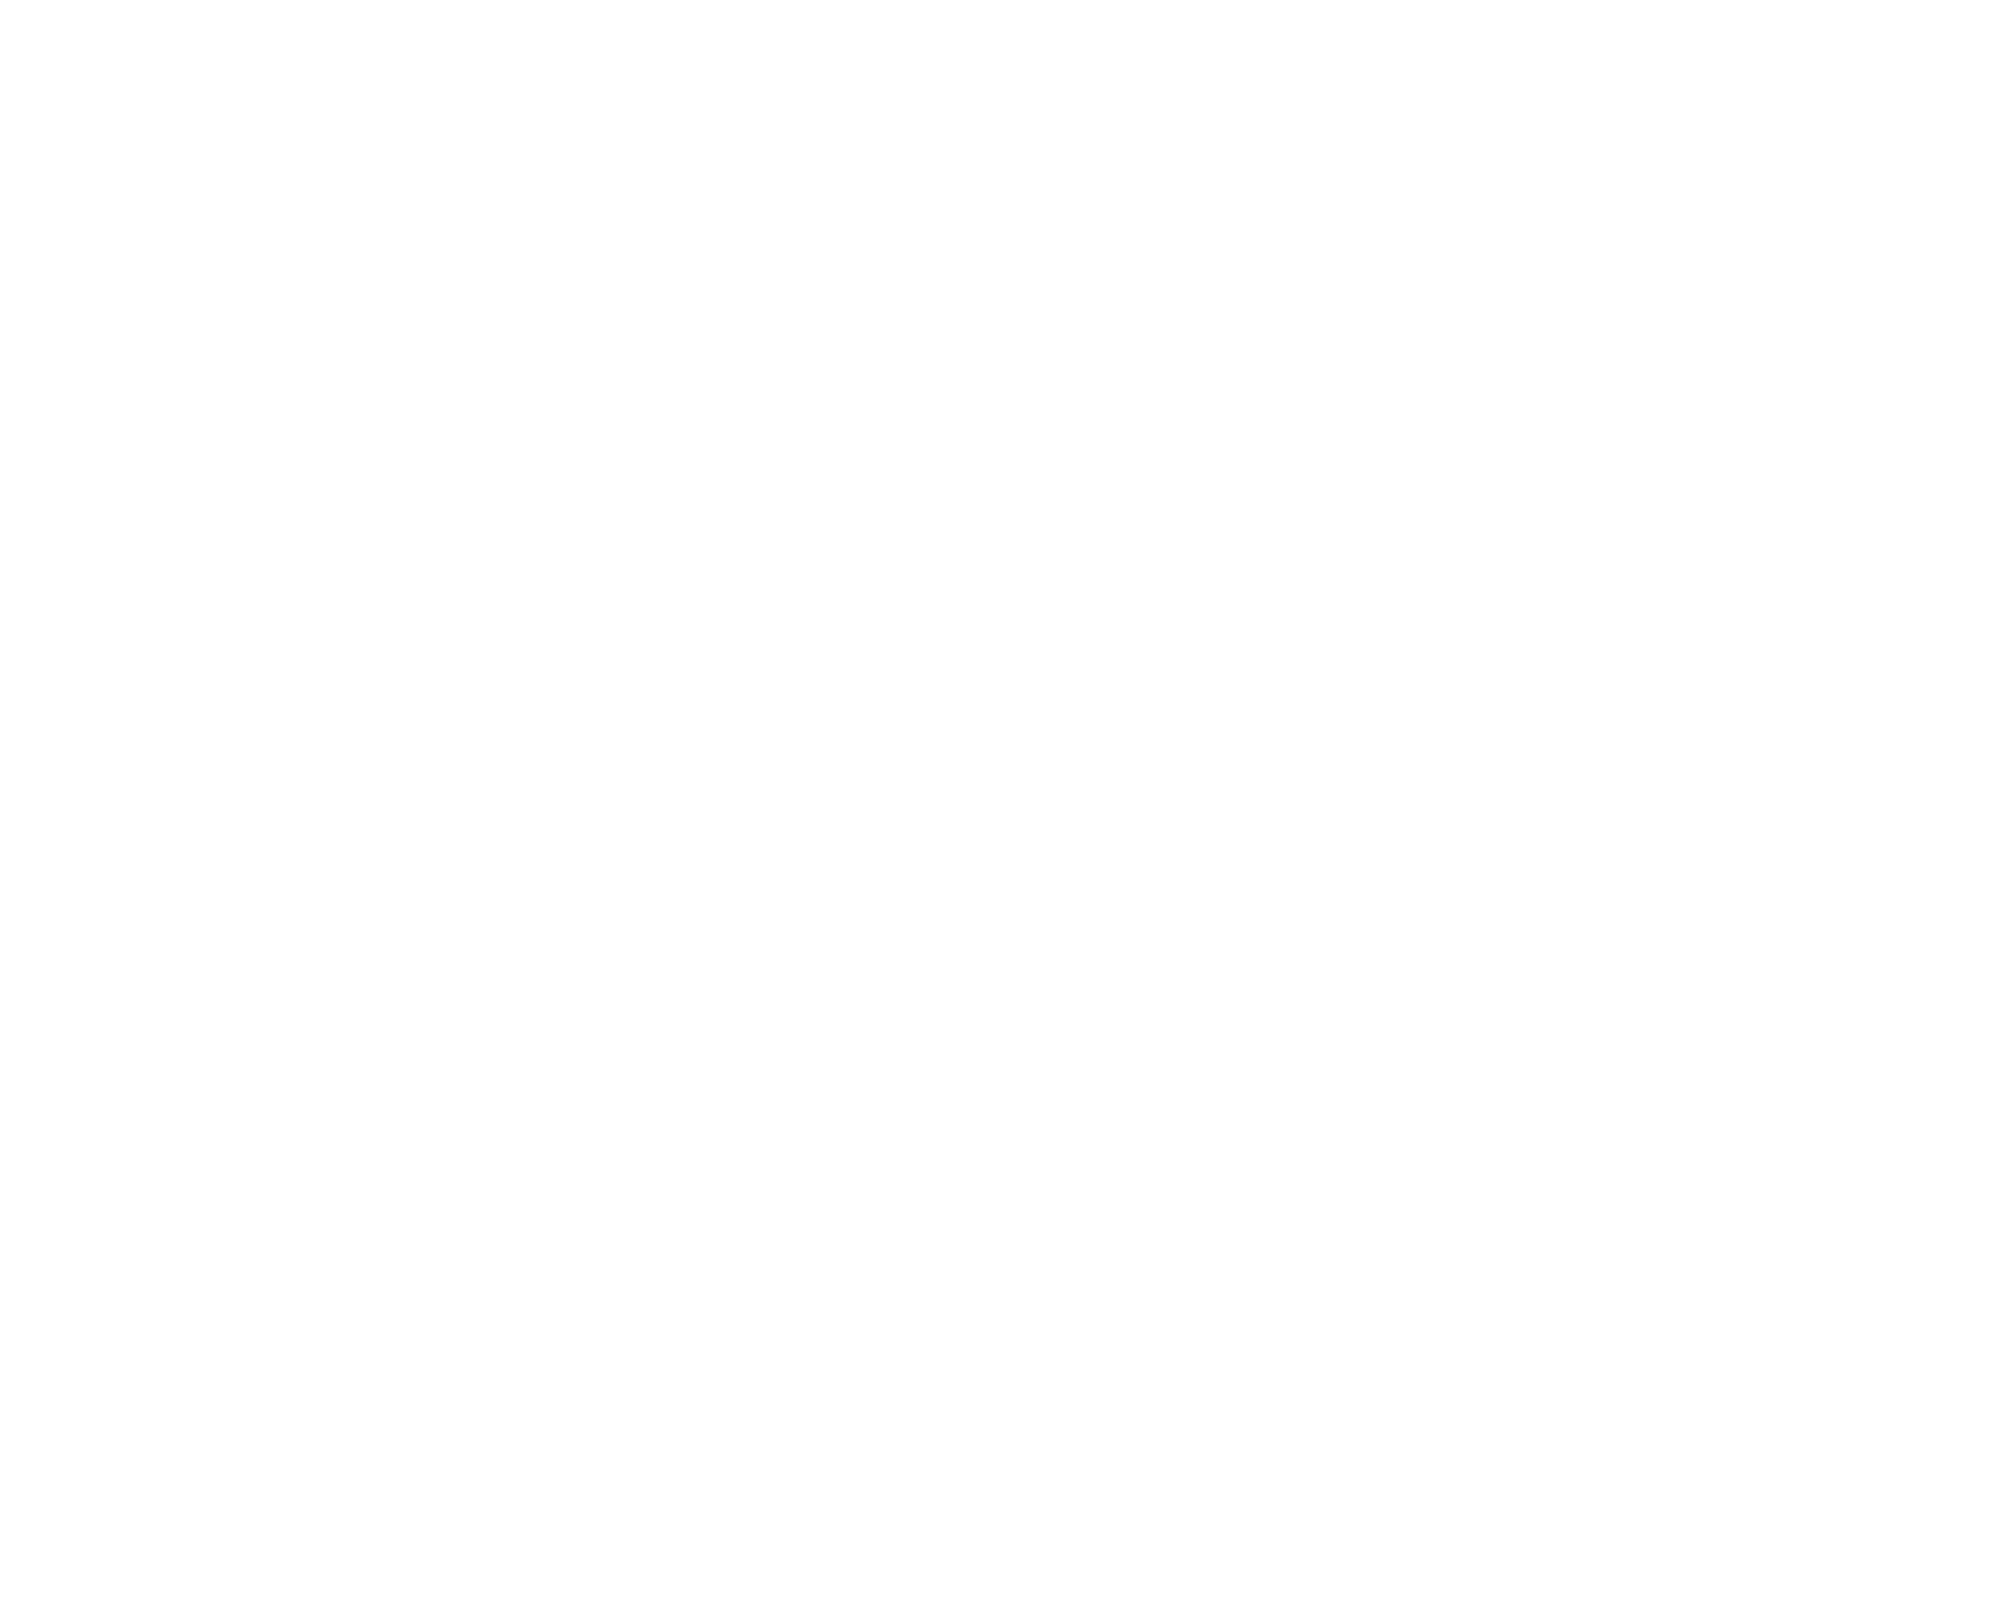

<IPython.core.display.Javascript object>

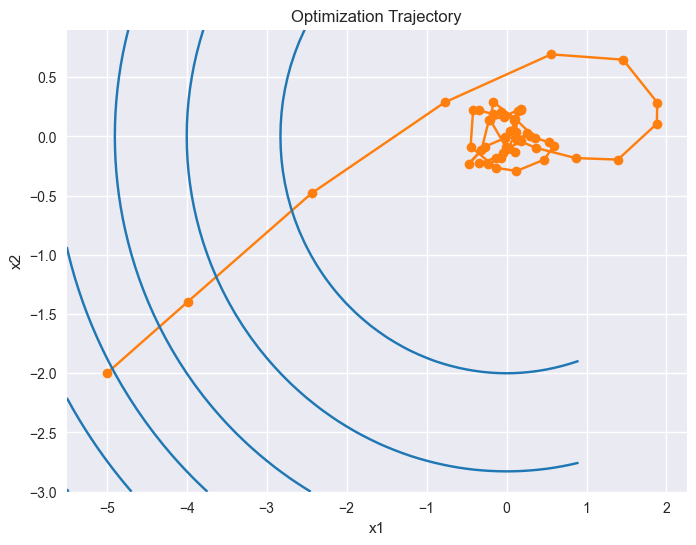

AttributeError: 'NoneType' object has no attribute 'remove_callback'

<IPython.core.display.Javascript object>

In [ ]:

def train_2d(trainer, steps=20, f_grad=None):
    x1, x2, s1, s2 = -5, -2, 0, 0 
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results

def show_trace_2d(f, results):
    plt.figure(figsize=(8, 6))
    plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = torch.meshgrid(torch.arange(-5.5, 1.0, 0.1),
                            torch.arange(-3.0, 1.0, 0.1))
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Optimization Trajectory')
    plt.show()

def constant_lr():
    return 1

eta = 0.1
lr = constant_lr  # Constant learning rate

# Train and visualize
optimizers = [nag]
names = ['NAG']

for optimizer, name in zip(optimizers, names):
    print(f"\nTraining with {name}:")
    results = train_2d(optimizer, steps=50, f_grad=f_grad)
    show_trace_2d(f, results)

# RMSprop (Root Mean Square Propagation) 

RMSprop (Root Mean Square Propagation) is an adaptive learning rate method that was designed to resolve the diminishing learning rates problem of AdaGrad.

The key idea behind RMSprop is to divide the learning rate for a weight by a running average of the magnitudes of recent gradients for that weight.

The update rules for RMSprop are:

$E[g^2]t = \beta E[g^2]{t-1} + (1-\beta) g_t^2$
$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{E[g^2]_t + \epsilon}} g_t$
Where:

$E[g^2]_t$ is the running average of squared gradients
$\beta$ is the decay rate
$\eta$ is the learning rate
$\epsilon$ is a small constant for numerical stability
$g_t$ is the gradient at time t
Let's implement RMSprop and visualize its behavior:

In [ ]:
def rmsprop(x1, x2, s1, s2, f_grad):
    beta = 0.9
    epsilon = 1e-6
    g1, g2 = f_grad(x1, x2)
    # Simulate noisy gradient
    g1 += torch.normal(0.0, 1, (1,))[0]
    g2 += torch.normal(0.0, 1, (1,))[0]
    s1 = beta * s1 + (1 - beta) * g1**2
    s2 = beta * s2 + (1 - beta) * g2**2
    eta_t = eta * lr()
    return (x1 - eta_t * g1 / (torch.sqrt(s1) + epsilon),
            x2 - eta_t * g2 / (torch.sqrt(s2) + epsilon),
            s1, s2)

In [168]:
def train_2d(trainer, steps=20, f_grad=None):
    x1, x2, s1, s2 = -5, -2, 0, 0 
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results


In [169]:
def show_trace_2d(f, results):
    plt.figure(figsize=(8, 6))
    plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = torch.meshgrid(torch.arange(-5.5, 1.0, 0.1),
                            torch.arange(-3.0, 1.0, 0.1))
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Optimization Trajectory')
    plt.show()



Training with RMSprop:
epoch 50, x1: -0.677104, x2: 0.049664


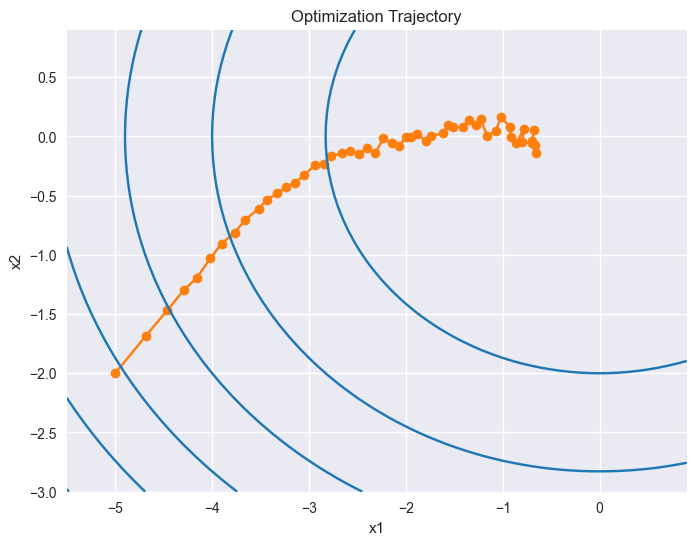

In [170]:
def constant_lr():
    return 1

eta = 0.1
lr = constant_lr  # Constant learning rate

# Train and visualize
optimizers = [rmsprop]
names = ['RMSprop']

for optimizer, name in zip(optimizers, names):
    print(f"\nTraining with {name}:")
    results = train_2d(optimizer, steps=50, f_grad=f_grad)
    show_trace_2d(f, results)

# Adam (Adaptive Moment Estimation)

Adam (Adaptive Moment Estimation) is another method that computes adaptive learning rates for each parameter. It stores both an exponentially decaying average of past gradients (like momentum) and an exponentially decaying average of past squared gradients.

The Adam update rule is:

$$m_t = β_1 * m_{t-1} + (1 - β_1) * g_t$$
$$v_t = β_2 * v_{t-1} + (1 - β_2) * g_t^2$$
$$m̂_t = m_t / (1 - β_1^t)$$
$$v̂_t = v_t / (1 - β_2^t)$$
$$θ_t = θ_{t-1} - η * m̂_t / (√v̂_t + ε)$$

Where:
- m_t is the first moment estimate
- v_t is the second moment estimate
- β_1 and β_2 are hyperparameters (usually set to 0.9 and 0.999 respectively)
- η is the learning rate
- ε is a small constant for numerical stability

Let's implement Adam:

In [171]:
# Adam
def adam(x1, x2, s1, s2, f_grad):
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8
    g1, g2 = f_grad(x1, x2)
    # Simulate noisy gradient
    g1 += torch.normal(0.0, 1, (1,))[0]
    g2 += torch.normal(0.0, 1, (1,))[0]
    s1 = (beta1 * s1[0] + (1 - beta1) * g1, beta2 * s1[1] + (1 - beta2) * g1**2)
    s2 = (beta1 * s2[0] + (1 - beta1) * g2, beta2 * s2[1] + (1 - beta2) * g2**2)
    eta_t = eta * lr()
    return (x1 - eta_t * s1[0] / (torch.sqrt(s1[1]) + epsilon),
            x2 - eta_t * s2[0] / (torch.sqrt(s2[1]) + epsilon),
            s1, s2)

In [172]:
def train_2d(trainer, steps=20, f_grad=None):
    # Initialize s1 and s2 as tuples of zeros
    x1, x2, s1, s2 = -5, -2, (0., 0.), (0., 0.)
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results


In [173]:
def show_trace_2d(f, results):
    plt.figure(figsize=(8, 6))
    plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = torch.meshgrid(torch.arange(-5.5, 1.0, 0.1),
                            torch.arange(-3.0, 1.0, 0.1))
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Optimization Trajectory')
    plt.show()



Training with Adam:
epoch 50, x1: -0.120571, x2: 0.147842


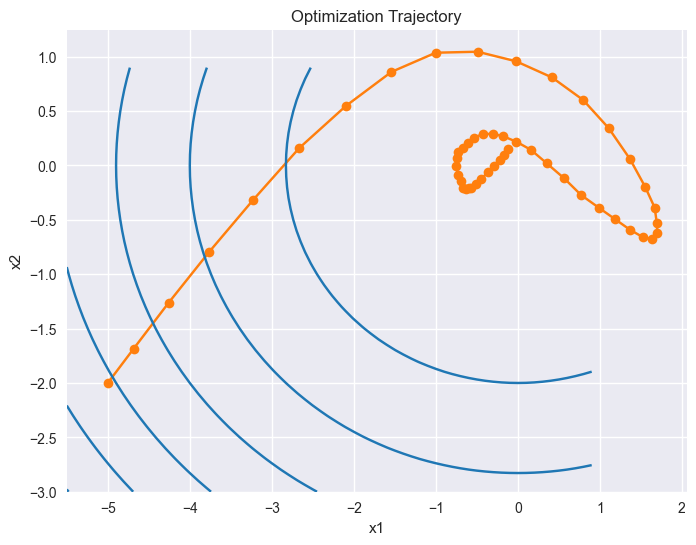

In [174]:
def constant_lr():
    return 1

eta = 0.1
lr = constant_lr  # Constant learning rate

# Train and visualize
optimizers = [adam]
names = ['Adam']

for optimizer, name in zip(optimizers, names):
    print(f"\nTraining with {name}:")
    results = train_2d(optimizer, steps=50, f_grad=f_grad)
    show_trace_2d(f, results)

# Comparison of Optimizers

In [225]:

def plot_contourf(cost_f, figsize=[10, 10], _show=True):
    fig = plt.figure(figsize=figsize)
    ax=fig.gca()
    x = np.arange(cost_f.xmin, cost_f.xmax, 0.1)
    y = np.arange(cost_f.ymin, cost_f.ymax, 0.1)
    X, Y = np.meshgrid(x, y)
    zs = np.array([cost_f.eval(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)
    Gx, Gy = np.gradient(Z) 
    G = (Gx**2.0+Gy**2.0)**.5  
    N = G/G.max()  
    ax.contourf(X, Y, Z, cmap=plt.cm.get_cmap(plt.cm.afmhot), levels=np.linspace(zs.min(), zs.max(), 1000))
    plt.text(cost_f.x_optimum, cost_f.y_optimum,"x", color="b", size=20)
    if _show:
        plt.show()
    return fig, ax


def plot_trajectories(trajectories_dict, cost_f, figsize=[10,10],
                     filepath="test.gif", frames=10):
    
    fig, ax = plot_contourf(cost_f=cost_f, figsize=[10, 10], _show=False)
    
    global dots; dots=[]
    def update(frame_number):
        global dots
        ax=fig.gca()
        for sc in dots: sc.remove()
        dots=[]
       
        for name, (x, y, c) in trajectories_dict.items():
            ax.plot(x[:frame_number], y[:frame_number], color=c, zorder=1, linewidth=2)
            k=ax.scatter(x[frame_number], y[frame_number], color=c, zorder=1, s=50)
            dots.append(k)

        plt.legend(trajectories_dict.keys())

    animation = FuncAnimation(fig, update, interval=1, frames=frames);
    animation.save(filepath, dpi=80, writer = "imagemagick");
    
    


def run_optimizer(opt, cost_f, iterations, *args, **kwargs):
    errors = [cost_f.eval(cost_f.x_start, cost_f.y_start)]
    xs,ys= [cost_f.x_start],[cost_f.y_start]
    for epochs in range(iterations):
        x, y= opt.step(*args, **kwargs)
        xs.append(x)
        ys.append(y)
        errors.append(cost_f.eval(x,y))
    distance = np.sqrt((np.array(xs)-cost_f.x_optimum)**2 + (np.array(ys)-cost_f.y_optimum)**2)
    return errors, distance, xs, ys

class Optimizer:
    def __init__(self, cost_f, lr, x, y, **kwargs):
        self.lr = lr
        self.cost_f = cost_f
        if x==None or y==None:
            self.x = self.cost_f.x_start
            self.y = self.cost_f.y_start
        else:
            self.x = x
            self.y = y
            
        self.__dict__.update(kwargs)
            
    def step(self, lr):
        raise NotImplementedError()
        

In [226]:
class Beale:
    def __init__(self):
        self.xmin, self.xmax = -1.5, 5
        self.ymin, self.ymax = -3, 1.5
        self.y_start, self.x_start = -2.8, 2.4  # Start point
        self.x_optimum, self.y_optimum, self.z_optimum = 3, 0.5, 0  # Global optimum 
        self._compute_derivatives()
        
    def _compute_derivatives(self):
        self.df_dx =grad(self.eval, 0) # Partial derivative of the objective function over x
        self.df_dy = grad(self.eval, 1) # Partial derivative of the objective function over y
        
    def eval(self, x, y):
        z = np.log(1+(1.5-x+x*y)**2 + (2.25-x+x*y**2)**2 + (2.625-x+x*y**3)**2)/10
        return z

In [227]:
iterations = 1500
learning_rate = 0.01
cost_f = Beale()

In [228]:
class SGD(Optimizer):
    def __init__(self, cost_f, lr=0.001, beta=0.9, x=None, y=None):
        super().__init__(cost_f=cost_f, lr=lr, x=x, y=y, beta=beta)
        self.vx = None
        
    def step(self, lr = None, beta=None):
        f = self.cost_f.eval(self.x, self.y)
        dx = self.cost_f.df_dx(self.x, self.y)
        dy = self.cost_f.df_dy(self.x, self.y)
        if type(lr) == type(None):
            lr = self.lr
        if type(beta) == type(None):
            beta = self.beta
        if type(self.vx) == type(None) or type(self.vy)==type(None):
            self.vx = lr * dx
            self.vy = lr * dy
        else:
            dx_in_vx = self.cost_f.df_dx(self.x-beta*self.vx, self.y-beta*self.vy)
            dy_in_vy = self.cost_f.df_dy(self.x-beta*self.vx, self.y-beta*self.vy)
            self.vx = beta * self.vx + lr * dx_in_vx
            self.vy = beta * self.vy + lr * dy_in_vy
        self.x += - self.vx
        self.y += - self.vy
            
        return [self.x, self.y]

In [229]:
opt=SGD(cost_f=cost_f, lr=learning_rate, beta=0.9)

In [230]:
errors_sgd, distance_sgd, xs_sgd, ys_sgd = run_optimizer(opt=opt, cost_f=cost_f, iterations=iterations)

In [231]:
class NAG(Optimizer):
    def __init__(self, cost_f, lr=0.001, beta=0.9, x=None, y=None):
        super().__init__(cost_f=cost_f, lr=lr, x=x, y=y, beta=beta)
        self.vx = 0
        self.vy = 0
        
    def step(self, lr=None, beta=None):
        if lr is None:
            lr = self.lr
        if beta is None:
            beta = self.beta
        
        # Nesterov momentum update
        x_lookahead = self.x - beta * self.vx
        y_lookahead = self.y - beta * self.vy
        
        dx = self.cost_f.df_dx(x_lookahead, y_lookahead)
        dy = self.cost_f.df_dy(x_lookahead, y_lookahead)
        
        self.vx = beta * self.vx + lr * dx
        self.vy = beta * self.vy + lr * dy
        
        self.x -= self.vx
        self.y -= self.vy
        
        return [self.x, self.y]

In [232]:
opt=NAG(cost_f=cost_f, lr=learning_rate, beta=0.9)

In [233]:
errors_nag, distance_nag, xs_nag, ys_nag = run_optimizer(opt=opt, cost_f=cost_f, iterations=iterations)

In [234]:
class RMSprop(Optimizer):
    def __init__(self, cost_f, lr=0.001, beta=0.9, eps=1e-8, x=None, y=None):
        super().__init__(cost_f=cost_f, lr=lr, x=x, y=y, beta=beta)
        self.eps = eps
        self.sq_dx = 0
        self.sq_dy = 0
        
    def step(self, lr=None, beta=None):
        if lr is None:
            lr = self.lr
        if beta is None:
            beta = self.beta
        
        dx = self.cost_f.df_dx(self.x, self.y)
        dy = self.cost_f.df_dy(self.x, self.y)
        
        self.sq_dx = beta * self.sq_dx + (1 - beta) * dx**2
        self.sq_dy = beta * self.sq_dy + (1 - beta) * dy**2
        
        self.x -= lr * dx / (np.sqrt(self.sq_dx) + self.eps)
        self.y -= lr * dy / (np.sqrt(self.sq_dy) + self.eps)
        
        return [self.x, self.y]

In [235]:
opt=RMSprop(cost_f=cost_f, lr=learning_rate, beta=0.9)

In [236]:
errors_rmsprop, distance_rmsprop,xs_rmsprop, ys_rmsprop = run_optimizer(opt=opt, cost_f=cost_f, iterations=iterations)

In [237]:
class Adam(Optimizer):
    def __init__(self, cost_f, lr=0.001, betas=(0.9, 0.999), eps=1e-8, x=None, y=None):
        super().__init__(cost_f=cost_f, lr=lr, x=x, y=y, betas=betas)
        self.betas = betas
        self.eps = eps
        self.m_dx = 0
        self.m_dy = 0
        self.v_dx = 0
        self.v_dy = 0
        self.t = 0
        
    def step(self, lr=None, betas=None):
        if lr is None:
            lr = self.lr
        if betas is None:
            betas = self.betas
        
        beta1, beta2 = betas
        
        self.t += 1
        
        dx = self.cost_f.df_dx(self.x, self.y)
        dy = self.cost_f.df_dy(self.x, self.y)
        
        self.m_dx = beta1 * self.m_dx + (1 - beta1) * dx
        self.m_dy = beta1 * self.m_dy + (1 - beta1) * dy
        
        self.v_dx = beta2 * self.v_dx + (1 - beta2) * dx**2
        self.v_dy = beta2 * self.v_dy + (1 - beta2) * dy**2
        
        m_dx_corr = self.m_dx / (1 - beta1**self.t)
        m_dy_corr = self.m_dy / (1 - beta1**self.t)
        
        v_dx_corr = self.v_dx / (1 - beta2**self.t)
        v_dy_corr = self.v_dy / (1 - beta2**self.t)
        
        self.x -= lr * m_dx_corr / (np.sqrt(v_dx_corr) + self.eps)
        self.y -= lr * m_dy_corr / (np.sqrt(v_dy_corr) + self.eps)
        
        return [self.x, self.y]

In [238]:
opt=Adam(cost_f=cost_f, lr=learning_rate, betas=(0.9,0.999))

In [239]:
errors_adam, distance_adam,xs_adam, ys_adam = run_optimizer(opt=opt, cost_f=cost_f, iterations=iterations)

In [241]:
trajectories_dict={"SGD": (xs_sgd, ys_sgd, "green"),  
                    "NAG": (xs_nag, ys_nag, "skyblue"),
                    "RMSprop": (xs_rmsprop, ys_rmsprop, "brown"),
                    "Adam": (xs_adam, ys_adam, "red")}

/var/folders/6_/dbz5pjq95szf2c5dmhvfxkv80000gn/T/ipykernel_45859/3883262105.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.contourf(X, Y, Z, cmap=plt.cm.get_cmap(plt.cm.afmhot), levels=np.linspace(zs.min(), zs.max(), 1000))
MovieWriter imagemagick unavailable; using Pillow instead.


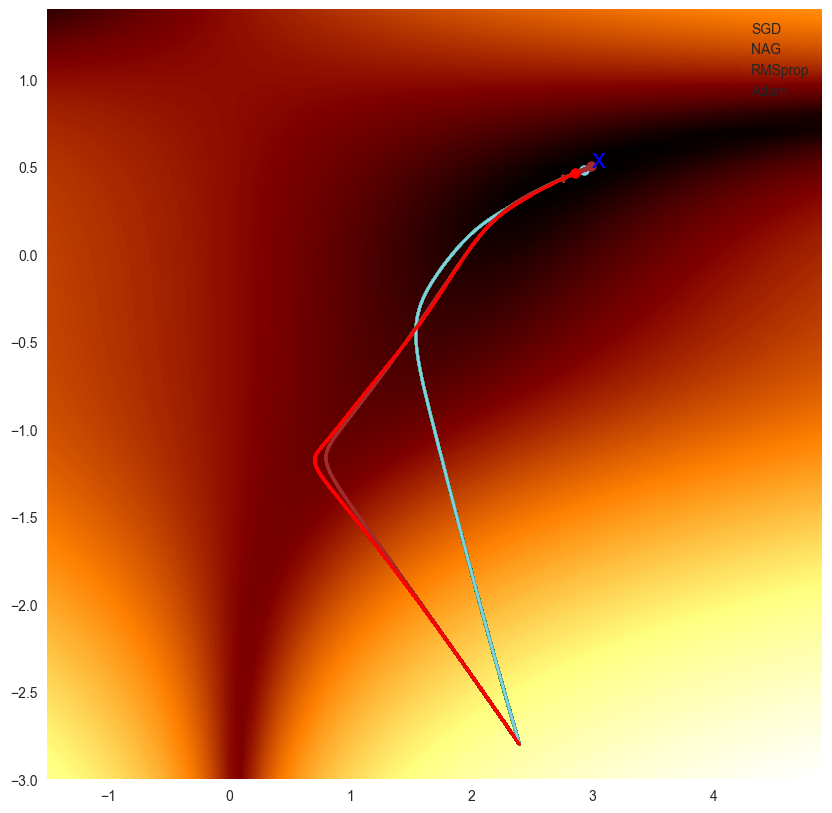

In [242]:
plot_trajectories(trajectories_dict, cost_f, figsize=[10,10], filepath="./trajectories.gif", frames=700)

# THANKS ☺️


I will try my best to keep updated and make the tutorial more comprehensive！

If you have any questions about the tutorial notebook, please contact juanxitian1031@gmail.com
